# Z-Score Normalization

In [5]:
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns
import torch

from geobench_v2.datamodules import GeoBenchBENV2DataModule
from geobench_v2.datasets import GeoBenchBENV2
from geobench_v2.datasets.normalization import (
    ClipOnlyNormalizer,
    ClipZScoreNormalizer,
    RescaleNormalizer,
    ZScoreNormalizer,
)
from geobench_v2.datasets.visualization_util import compare_normalization_methods

sns.set_palette("deep")
plt.rcParams["figure.figsize"] = [12, 8]
plt.rcParams["font.size"] = 12

# Define project root
PROJECT_ROOT = Path("../../")

# Understanding ZScoreNormalizer in Detail

This notebook provides an in-depth explanation of the ZScoreNormalizer used in GeoBench2. Generally, the way we normalize our input data can have significant impacts on training dynamics and performance. While in standard computer vision with normal RGB imagery normalization is usually straight forward since all imagery falls into a fixed [0, 255] range. However, in the Earth Observation (EO) domain, there exist a large variety of satellites that not only measure bands beyond the common RGB bands, but also do so in different ranges. One recent study about the impact of normalization on pretrained models specifically was done by [Corley et al. 2024](https://openaccess.thecvf.com/content/CVPR2024W/PBVS/papers/Corley_Revisiting_Pre-trained_Remote_Sensing_Model_Benchmarks_Resizing_and_Normalization_Matters_CVPRW_2024_paper.pdf), who show that normalization and resizing has a considerable effect on model performance of pretrained RGB ImageNet models which are often considered as baseline models.

One goal of GeoBenchV2 is to provide a set of normalization tools that easily let you experiment with different normalization schemes, inspect the effect of them, and find the best normalization scheme for different pretrained models.


In this tutorial notebook, we will showcase the `ZScoreNormalizer` module, which normalizes the data with the goal of approximate zero mean and unit variance.

## Loading BigEarthNet V2 Data

First, let's load some actual Sentinel data from the BENV2 dataset. The `GeoBenchBENV2DataModule` holds all the imporant information that make up a dataset for experimentation purposes. The `data_normalizer` argument accepts a `torch.nn.Module` that will be applied on every sample loaded from the `__getitem__` method of the underlying dataset class. Since we want to just illustrate the effect of different normalization schemes, we will pass `nn.Identiy()` to return "raw" data that is unchanged.

BENV2 has two modalities: Sentinel 1 and Sentinel 2 data, that both have different number of bands, and different ranges of values.

In [6]:
band_order = GeoBenchBENV2.band_default_order

datamodule = GeoBenchBENV2DataModule(
    img_size=120,
    batch_size=16,
    num_workers=4,
    root=PROJECT_ROOT / "data" / "benv2",
    band_order=band_order,
    data_normalizer=torch.nn.Identity(),  # we do custom normalization in the tutorial
)
datamodule.setup("fit")

train_dataloader = datamodule.train_dataloader()
raw_batch = next(iter(train_dataloader))

Using provided pre-initialized normalizer instance: Identity
Using provided pre-initialized normalizer instance: Identity


## Load and Prepare Statistics for Normalization

In [7]:
stats_path = str(
    PROJECT_ROOT
    / "geobench_v2/generate_benchmark/dataset_stats_with_clip/benv2/benv2_stats.json"
)

zscore_normalizer = ZScoreNormalizer(stats_path, band_order)
rescale_normalizer = RescaleNormalizer(stats_path, band_order, output_range="zero_one")
clip_zscore_normalizer = ClipZScoreNormalizer(stats_path, band_order)

clip_only = ClipOnlyNormalizer(stats_path, band_order)

## How ZScoreNormalizer Works

The `ZScoreNormalizer` performs normalization using z-score: $(x - \mu) / \sigma$, where $\mu$ and $\sigma$ are channel wise mean and std values computed over the training dataset.

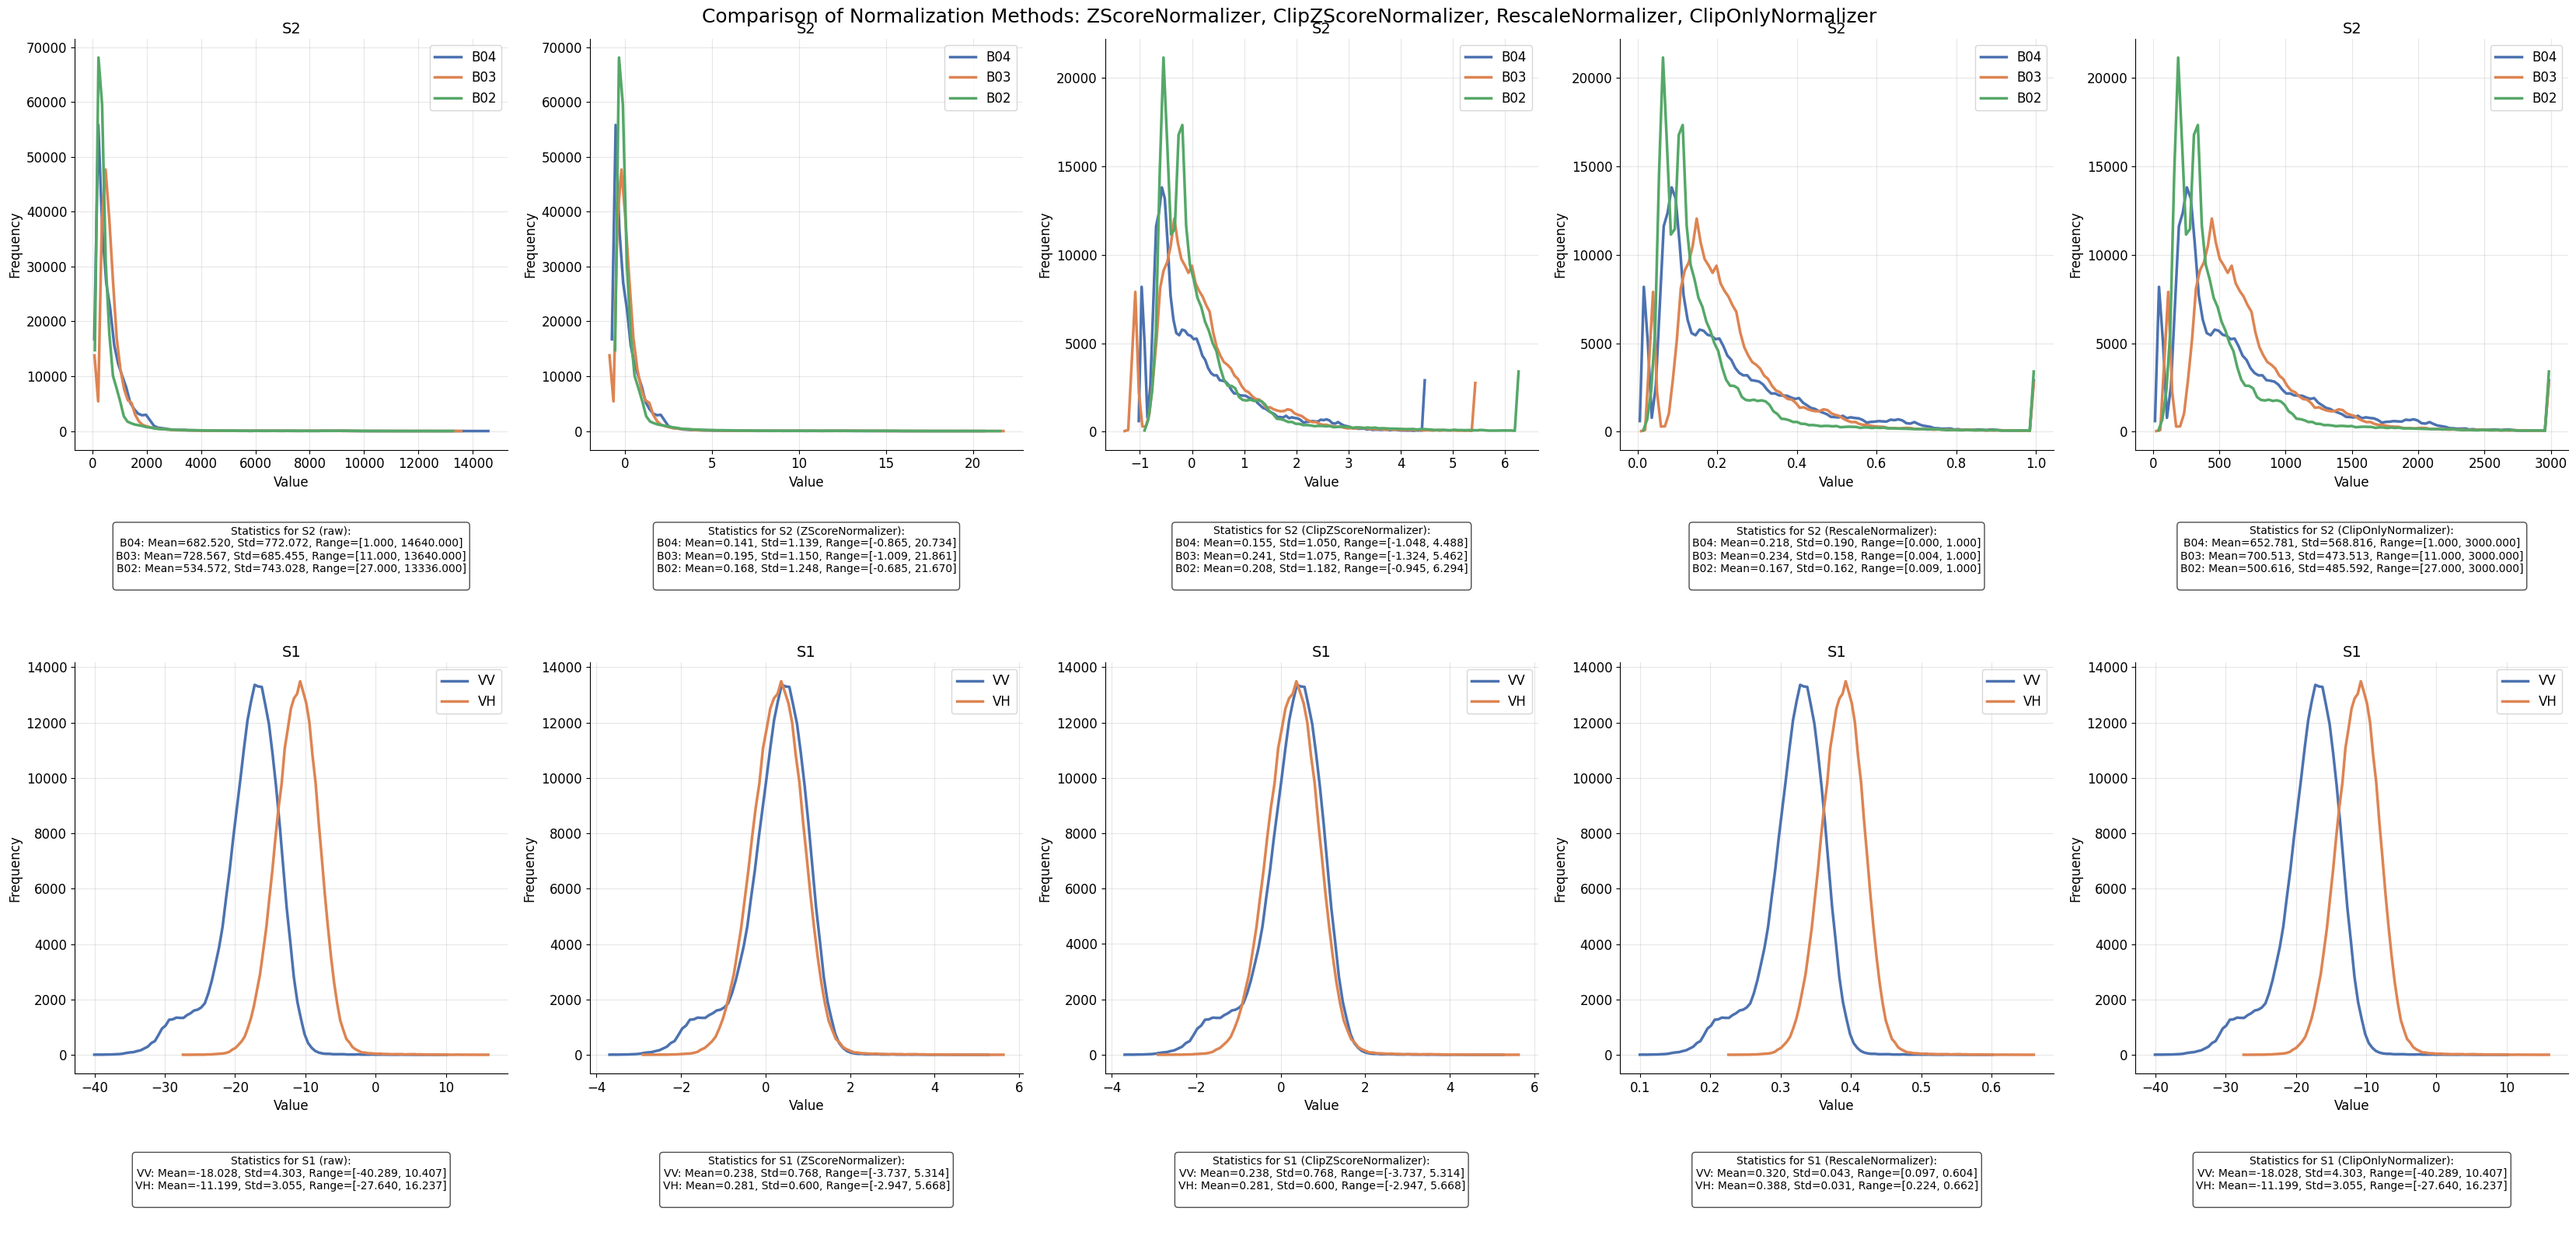

In [8]:
fig, batches = compare_normalization_methods(
    raw_batch,
    [zscore_normalizer, clip_zscore_normalizer, rescale_normalizer, clip_only],
    datamodule,
)